In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import xarray as xr

import cartopy
import cartopy.crs as ccrs
import numpy.ma as ma
import matplotlib.colors as colors
from statistics import mode
import pandas as pd
from scipy import signal
from cartopy.util import add_cyclic_point

home_dir = '/glade/work/devond/'
import sys  
sys.path.insert(0, home_dir)

from functions import * 

crs_sp = ccrs.SouthPolarStereo(central_longitude=0)
crs_ll = ccrs.PlateCarree()

In [2]:
### ----- Read ICE SHEET MASK data ----- ###
mask_file = '/glade/work/devond/AIS_masks/model_masks/CESM_masks.nc'
cesm_masks = xr.open_dataset(mask_file)
cesm_masks = cesm_masks.sel(lat = slice(-90,-60))

cesm_ism = cesm_masks.full_ism.values #full ice sheet
cesm_ism[cesm_ism>0] = 1
cesm_area = cesm_masks.area.values #grid cell areas


lon = cesm_masks.lon
lat = cesm_masks.lat
cesm_ism2, lon2 = add_cyclic_point(cesm_ism, coord=lon)

/glade/work/devond/my_npl_clone/lib/python3.6/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in greater
  import sys


In [3]:
cesm2 = xr.open_dataset(f'/glade/work/devond/CESM/melt/CESM2_QSNOMELT_hist.nc')['QSNOMELT']
cesm2 = cesm2.sel(lat = slice(-90,-60))
cesm2 = cesm2.sel(time = slice('1979-01-01','2015-01-01'))* cesm_ism * 3600*24*cesm2.time.dt.days_in_month
cesm2_map = cesm2.groupby(cesm2.time.dt.year).sum().mean(dim = 'year')

In [4]:
cesm1 = xr.open_dataset(f'/glade/work/devond/CESM/melt/CESM1lens_QSNOMELT_hist.nc')['QSNOMELT']
cesm1 = cesm1.sel(time = slice('1979-01-01','2015-01-01'))* cesm_ism * 3600*24*cesm1.time.dt.days_in_month
cesm1_map = cesm1.groupby(cesm1.time.dt.year).sum().mean(dim = 'year')

In [5]:
qscat = xr.open_dataset('/glade/work/devond/QSCAT/QS_melt_Trusel_regrid.nc')['Band1']
qscat = qscat.sel(lat = slice(-90,-60))

In [13]:
relative_bias = (cesm2_map - qscat)/cesm2_map

cesm_year = cesm2.mean(dim = 'ensemble').groupby(cesm2.time.dt.year).sum()
cesm_trend, cesm_p = calculate_trend(cesm_year.values)
cesm_trend, lon2 = add_cyclic_point(cesm_trend, coord = lon)

cesm_norm = (cesm_year - cesm_year.mean(dim = 'year'))/cesm_year.std(dim = 'year')
cesm_trend_norm, cesm_p_norm = calculate_trend(cesm_norm.values)
cesm_trend_norm, lon2 = add_cyclic_point(cesm_trend_norm, coord = lon)

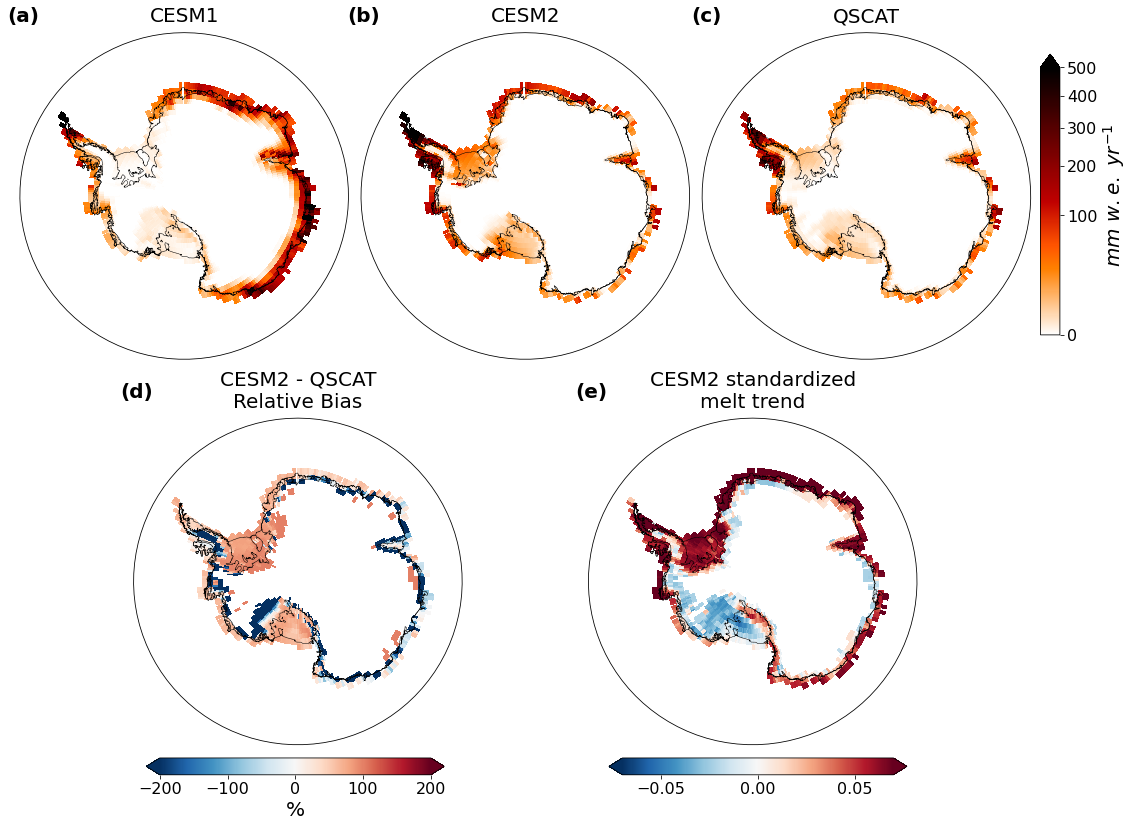

In [14]:
fig = plt.figure(figsize = (18,13))
plt.rcParams['axes.titlepad'] =14
gs = GridSpec(2, 9)
#gs.update(wspace=0.5)

ax1 = plt.subplot(gs[0, :3],projection=crs_sp)
plot_antarctica(ax1, -60)
im1 = ax1.pcolormesh(lon, lat, cesm1_map.mean(dim = 'ensemble')*cesm_ism, transform = crs_ll, cmap = 'gist_heat_r', norm=colors.PowerNorm(gamma=0.5), vmin = 0, vmax = 500)
ax1.set_title('CESM1', fontsize = 20)
ax1.text(0.05, 1.09, '(a)', transform=ax1.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax2 = plt.subplot(gs[0, 3:6],projection=crs_sp)
plot_antarctica(ax2, -60)
im2 = ax2.pcolormesh(lon, lat, cesm2_map.mean(dim = 'ensemble')*cesm_ism, transform = crs_ll, cmap = 'gist_heat_r', norm=colors.PowerNorm(gamma=0.5), vmin = 0, vmax = 500)
ax2.set_title('CESM2', fontsize = 20)
ax2.text(0.05, 1.09, '(b)', transform=ax2.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax3 = plt.subplot(gs[0, 6:],projection=crs_sp)
plot_antarctica(ax3, -60)
im3 = ax3.pcolormesh(lon, lat, qscat*cesm_ism, transform = crs_ll,  cmap = 'gist_heat_r', norm=colors.PowerNorm(gamma=0.5), vmin = 0, vmax = 500)
ax3.set_title('QSCAT', fontsize = 20)
ax3.text(0.05, 1.09, '(c)', transform=ax3.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax4 = plt.subplot(gs[1, 1:4],projection=crs_sp)
plot_antarctica(ax4, -60)
im4 = ax4.pcolormesh(lon, lat, relative_bias.mean(dim = 'ensemble')*cesm_ism*100, transform = crs_ll,  cmap = 'RdBu_r', vmin = -200, vmax = 200)
ax4.set_title('CESM2 - QSCAT\nRelative Bias', fontsize = 20)
ax4.text(0.05, 1.12, '(d)', transform=ax4.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

ax5 = plt.subplot(gs[1, 5:8],projection=crs_sp)
plot_antarctica(ax5, -60)
im5 = ax5.pcolormesh(lon2, lat, cesm_trend_norm*cesm_ism2, transform = crs_ll, cmap = 'RdBu_r',vmin = -0.07, vmax = 0.07)
ax5.set_title('CESM2 standardized\nmelt trend', fontsize = 20)
ax5.text(0.05, 1.12, '(e)', transform=ax5.transAxes, fontsize=20, fontweight='bold', va='top', ha='right')

#fig.subplots_adjust(bottom=0.01)
cbar_ax = fig.add_axes([0.91, 0.56, 0.015, 0.3])
cb = fig.colorbar(im1, cax=cbar_ax, orientation = 'vertical', extend = 'max')
cb.set_label(label='$mm~w.e.~yr^{-1}$', size=20)
cb.ax.tick_params(labelsize=16)

cbar_ax = fig.add_axes([0.22, 0.09, 0.23, 0.018])
cb = fig.colorbar(im4, cax=cbar_ax, orientation = 'horizontal', extend = 'both')
cb.set_label(label=f'%', size=20)
cb.ax.tick_params(labelsize=16)

cbar_ax = fig.add_axes([0.577, 0.09, 0.23, 0.018])
cb = fig.colorbar(im5, cax=cbar_ax, orientation = 'horizontal', extend = 'both', ticks=[-0.05, 0, 0.05])
cb.ax.tick_params(labelsize=16)

plt.savefig('melt.png', dpi = 300, bbox_inches = 'tight', transparent = True)
plt.show()


## AIS melt

In [15]:
masks = xr.open_dataset(mask_file)
masks = masks.sel(lat = slice(-90,-60))

full_ism = masks.full_ism.values

In [16]:
east = masks.east.values

west = masks.west.values

pen = masks.peninsula.values

cesm1_ts = cesm1.groupby(cesm1.time.dt.year).sum()
cesm2_ts = cesm2.groupby(cesm2.time.dt.year).sum()

In [17]:
cesm1_ts

<xarray.DataArray (ensemble: 42, year: 27, lat: 32, lon: 288)>
array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]],


       [[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0

In [44]:
qscat_ais = (((qscat*cesm_area*full_ism)/(10**12)).sum().values)
cesm2_ais = (((cesm2_ts*cesm_area*full_ism)/(10**12)).sum(dim = ['lat','lon']))
cesm1_ais = (((cesm1_ts*cesm_area*full_ism)/(10**12)).sum(dim = ['lat','lon']))

cesm2_ais_std =np.mean(cesm2_ais.std(dim = 'year').values)
cesm1_ais_std =np.mean(cesm1_ais.std(dim = 'year').values)

print(f'Melt from QSCAT = {qscat_ais:0.2f} Gt/yr')
print(f'Melt from CESM2 = {cesm2_ais.mean().values:0.1f} +\- {cesm2_ais_std:0.1f} Gt/yr')
print(f'Melt from CESM1 = {cesm1_ais.mean().values:0.1f} +\- {cesm1_ais_std:0.1f} Gt/yr')


Melt from QSCAT = 104.33 Gt/yr
Melt from CESM2 = 176.7 +\- 37.1 Gt/yr
Melt from CESM1 = 298.9 +\- 49.9 Gt/yr


In [46]:
cesm1_ais.isel(ensemble=31).std()

<xarray.DataArray ()>
array(51.86617883)

## By Region

In [43]:
qscat_p = (((qscat*cesm_area*pen)/(10**12)).sum().values)
qscat_w = (((qscat*cesm_area*west)/(10**12)).sum().values)
qscat_e = (((qscat*cesm_area*east)/(10**12)).sum().values)

In [47]:
cesm1_p = (((cesm1_ts*cesm_area*pen)/(10**12)).sum(dim = ['lat', 'lon']).mean(dim = 'year').values)
cesm1_w = (((cesm1_ts*cesm_area*west)/(10**12)).sum(dim = ['lat', 'lon']).mean(dim = 'year').values)
cesm1_e = (((cesm1_ts*cesm_area*east)/(10**12)).sum(dim = ['lat', 'lon']).mean(dim = 'year').values)


In [48]:
cesm2_p = (((cesm2_ts*cesm_area*pen)/(10**12)).sum(dim = ['lat', 'lon']).mean(dim = 'year').values)
cesm2_w = (((cesm2_ts*cesm_area*west)/(10**12)).sum(dim = ['lat', 'lon']).mean(dim = 'year').values)
cesm2_e = (((cesm2_ts*cesm_area*east)/(10**12)).sum(dim = ['lat', 'lon']).mean(dim = 'year').values)


In [57]:
cesm2_p

array([74.07915038, 81.96669927, 74.76738703, 75.78368962, 77.84420348,
       72.17908539, 76.8657757 , 81.50177406, 77.63931855, 78.06479443,
       75.88348691])

In [64]:
print('Peninsula:')
print(f'QSCAT melt = {qscat_p:0.2f} Gt/yr')
print(f'CESM2 melt = {cesm2_p.mean():0.2f} +/- {cesm2_p.std():0.2f} Gt/yr ({(cesm2_p.mean() - qscat_p)*100/qscat_p:0.0f}% +/- {((cesm2_p.mean() - qscat_p)*100/qscat_p) - ((cesm2_p.mean() - cesm2_p.std() - qscat_p)*100/qscat_p):0.0f}%)')
print(f'CESM1 melt = {cesm1_p.mean():0.2f} +/- {cesm1_p.std():0.2f} Gt/yr ({(cesm1_p.mean() - qscat_p)*100/qscat_p:0.0f}% +/- {((cesm1_p.mean() - qscat_p)*100/qscat_p) - ((cesm1_p.mean() - cesm1_p.std() - qscat_p)*100/qscat_p):0.0f}%)')

Peninsula:
QSCAT melt = 47.65 Gt/yr
CESM2 melt = 76.96 +/- 2.81 Gt/yr (62% +/- 6%)
CESM1 melt = 25.02 +/- 1.91 Gt/yr (-47% +/- 4%)


In [65]:
print('WAnt:')
print(f'QSCAT melt = {qscat_w:0.2f} Gt/yr')
print(f'CESM2 melt = {cesm2_w.mean():0.2f} +/- {cesm2_w.std():0.2f} Gt/yr ({(cesm2_w.mean() - qscat_w)*100/qscat_w:0.0f}% +/- {((cesm2_w.mean() - qscat_w)*100/qscat_w) - ((cesm2_w.mean() - cesm2_w.std() - qscat_w)*100/qscat_w):0.0f}%)')
print(f'CESM1 melt = {cesm1_w.mean():0.2f} +/- {cesm1_w.std():0.2f} Gt/yr ({(cesm1_w.mean() - qscat_w)*100/qscat_w:0.0f}% +/- {((cesm1_w.mean() - qscat_w)*100/qscat_w) - ((cesm1_w.mean() - cesm1_w.std() - qscat_w)*100/qscat_w):0.0f}%)')

WAnt:
QSCAT melt = 13.18 Gt/yr
CESM2 melt = 38.59 +/- 3.28 Gt/yr (193% +/- 25%)
CESM1 melt = 5.24 +/- 0.73 Gt/yr (-60% +/- 6%)


In [66]:
print('EAnt:')
print(f'QSCAT melt = {qscat_e:0.2f} Gt/yr')
print(f'CESM2 melt = {cesm2_e.mean():0.2f} +/- {cesm2_e.std():0.2f} Gt/yr ({(cesm2_e.mean() - qscat_e)*100/qscat_e:0.0f}% +/- {((cesm2_e.mean() - qscat_e)*100/qscat_e) - ((cesm2_e.mean() - cesm2_e.std() - qscat_e)*100/qscat_e):0.0f}%)')
print(f'CESM1 melt = {cesm1_e.mean():0.2f} +/- {cesm1_e.std():0.2f} Gt/yr ({(cesm1_e.mean() - qscat_e)*100/qscat_e:0.0f}% +/- {((cesm1_e.mean() - qscat_e)*100/qscat_e) - ((cesm1_e.mean() - cesm1_e.std() - qscat_e)*100/qscat_e):0.0f}%)')

EAnt:
QSCAT melt = 43.50 Gt/yr
CESM2 melt = 61.10 +/- 4.85 Gt/yr (40% +/- 11%)
CESM1 melt = 268.60 +/- 10.29 Gt/yr (517% +/- 24%)


## Ice shelves vs grounded


In [144]:
x1 = masks.full_ism.values
x1[np.isnan(x1)] = 0

grounded = masks.grounded_ism.values
grounded[np.isnan(grounded)] = 0

ice_shelf_mask = x1 - grounded

In [151]:
qscat_is = (((qscat*cesm_area*ice_shelf_mask)/(10**12)).sum().values)
qscat_g = (((qscat*cesm_area*grounded)/(10**12)).sum().values)

cesm2_is = (((cesm2_ts*cesm_area*ice_shelf_mask)/(10**12)).sum(dim = ['lat', 'lon']).mean().values)
cesm2_g = (((cesm2_ts*cesm_area*grounded)/(10**12)).sum(dim = ['lat', 'lon']).mean().values)

cesm1_is = (((cesm1_ts*cesm_area*ice_shelf_mask)/(10**12)).sum(dim = ['lat', 'lon']).mean().values)
cesm1_g = (((cesm1_ts*cesm_area*grounded)/(10**12)).sum(dim = ['lat', 'lon']).mean().values)

In [152]:
print(qscat_is)
print(cesm2_is)
print(cesm1_is)
print((cesm2_is-qscat_is)/qscat_is)
print((cesm1_is-qscat_is)/qscat_is)

72.22860176053209
124.0576182125348
65.63167494077328
0.7175691511215668
-0.09133399593737627


In [153]:
print(qscat_g)
print(cesm2_g)
print(cesm1_g)
print((cesm2_g-qscat_g)/qscat_g)
print((cesm1_g-qscat_g)/qscat_g)

32.10235225816663
52.594635997955464
233.21918228717894
0.6383421244334432
6.264862724439436
